In [1]:
import deeptrack as dt 
import deeplay as dl
import kornia
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

2023-12-20 23:10:08.284766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = 51

particle = dt.PointParticle(
	position=lambda:np.random.uniform(
		image_size / 2 - 5, 
		image_size / 2 + 5, 
		size=2,
	),
)

In [3]:
optics = dt.Fluorescence(
	output_region=(0, 0, image_size, image_size),
)

In [4]:
simulation = (
    optics(particle) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)    

test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)
train_dataset = dt.pytorch.Dataset(simulation, length=100)


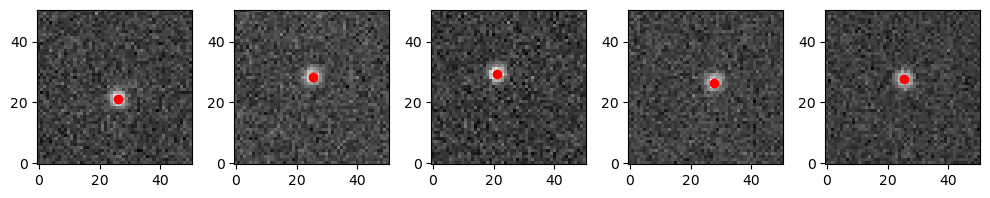

In [5]:
plt.figure(figsize=(10, 2))
for i in range(5):
	image, position = test_dataset[i]
	plt.subplot(1, 5, i + 1)
	plt.imshow(image[0], cmap="gray", origin="lower")
	plt.scatter(position[1], position[0], c="r")
plt.tight_layout()

plt.show()

# Lodestar

In [6]:
backbbone = dl.ConvolutionalNeuralNetwork(in_channels=1,
                                          hidden_channels=[16, 32, 64],
                                          out_channels=128,
                                          pool=nn.MaxPool2d(2))
model = dl.Sequential(backbbone,
                      nn.Flatten(),
                      nn.LazyLinear(2)).create() # We use LazyLinear to not have to calculate the output size of the cnn

print(model)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (3): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We define the transformation we want to apply and be consistent to.

In [7]:
def image_translation(batch, translation):
    # Flip the translation to match the image coordinate system
    xy_flipped_translation = translation[:, [1, 0]]
    return kornia.geometry.transform.translate(batch, xy_flipped_translation, padding_mode="reflection")

def inverse_translation(predicted_position, applied_translation):
    return predicted_position - applied_translation

In [8]:
class ParticleLocalizer(dl.Application):
    def __init__(self, model, n_transforms=8, **kwargs):
        self.model = model
        self.n_transforms = n_transforms
        super().__init__(**kwargs)

    def forward(self, x):
        return self.model(x)
    
    def random_arguments(self):
        return {
            "translation": torch.rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5
        }

    def forward_transform(self, x, translation):
        return image_translation(x, translation)

    def inverse_transform(self, x, translation):
        return inverse_translation(x, translation)

    def training_step(self, image, batch_idx):

        image, *_ = image
        # Create a batch of images by applying random translations
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        # get arguments for the random transforms
        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        # Predict the position of the particle
        predicted_position = self(transformed_batch)
        # Invserse the translation to get the predicted position in the original image
        predicted_position = self.inverse_transform(predicted_position, **kwargs)

        # Get average predicted position
        average_predicted_position = (
            predicted_position
            .mean(dim=0, keepdim=True)
            .repeat(self.n_transforms, 1) # repeat the average position to match the batch size
        )

        # Calculate the loss. We minimize the distance between each prediction and their average
        # which effectively minimizes the variance of the predictions on the original image.
        loss = self.loss(predicted_position, average_predicted_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

In [9]:
localizer = ParticleLocalizer(model, 
                              n_transforms=8, 
                              loss=nn.L1Loss(),
                              optimizer=dl.Adam(lr=5e-4)).create()

In [10]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


(20.002353205923992,
 30.995317266979466,
 -6.868128752708435,
 26.517529940605165)

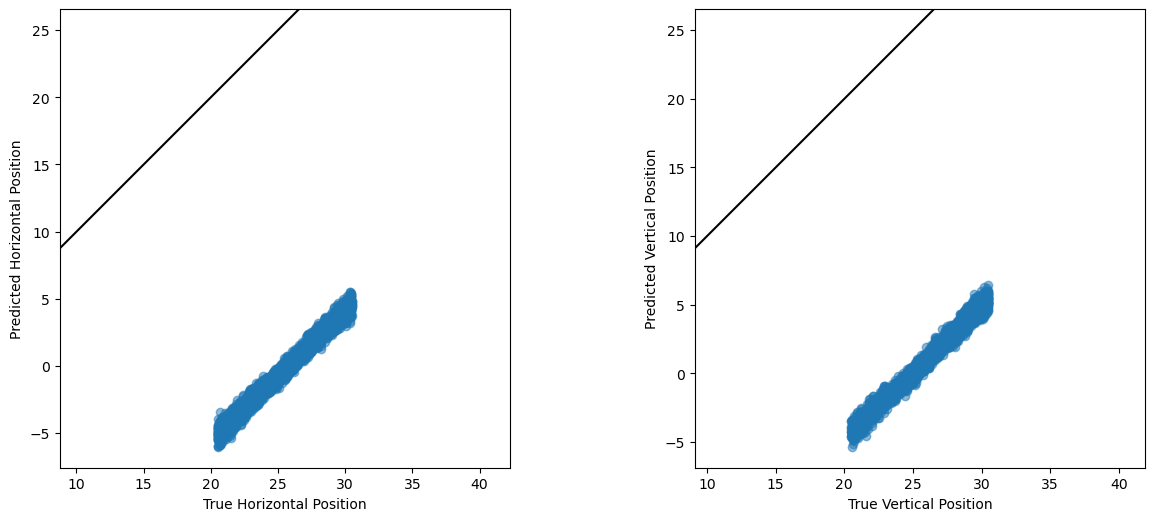

In [11]:
test_images, test_gt = zip(*test_dataset)

test_images = torch.stack(test_images)
test_gt = torch.stack(test_gt)

predictions = localizer(test_images).detach().numpy()

plt.figure(figsize=(14, 8))
grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)


plt.subplot(grid[1:, :3])
plt.scatter(test_gt[:, 0], predictions[:, 0], alpha=.5) 
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Horizontal Position")
plt.ylabel("Predicted Horizontal Position")
plt.axis("equal")

plt.subplot(grid[1:, 4:])
plt.scatter(test_gt[:, 1], predictions[:, 1], alpha=.5)
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Vertical Position")
plt.ylabel("Predicted Vertical Position")
plt.axis("equal")

(20.002353205923992,
 30.995317266979466,
 19.246376991271973,
 31.592318534851074)

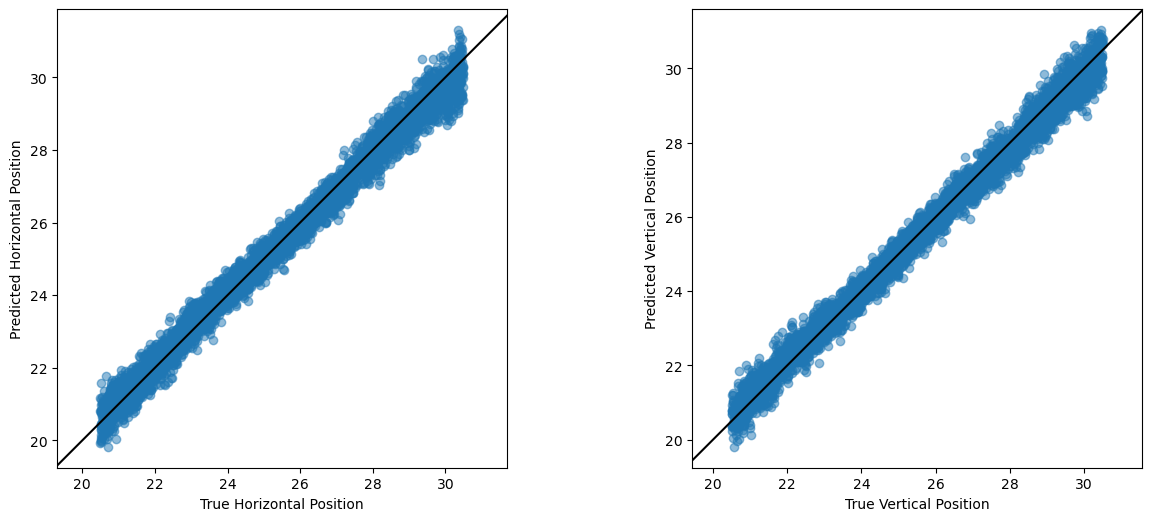

In [12]:
reflected_images = test_images.flip(dims=(2, 3))

direct_predictions = localizer(test_images).detach().numpy()
reflected_predictions = localizer(reflected_images).detach().numpy()

predictions = (direct_predictions - reflected_predictions) / 2 + image_size / 2 - 0.5

plt.figure(figsize=(14, 8))
grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

plt.subplot(grid[1:, :3])
plt.scatter(test_gt[:, 0], predictions[:, 0], alpha=.5) 
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Horizontal Position")
plt.ylabel("Predicted Horizontal Position")
plt.axis("equal")

plt.subplot(grid[1:, 4:])
plt.scatter(test_gt[:, 1], predictions[:, 1], alpha=.5)
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Vertical Position")
plt.ylabel("Predicted Vertical Position")
plt.axis("equal")


In [13]:
def flip_transform(image, should_flip, dim):
    should_flip = should_flip.view(-1, 1, 1, 1)
    image = torch.where(should_flip, image.flip(dims=(dim,)), image)
    return image

def inverse_flip_transform(x, should_flip, dim):
    should_flip_mask = torch.zeros_like(x).bool()
    should_flip_mask[should_flip, dim] = 1
    x = torch.where(should_flip_mask, -x, x)
    return x


class ParticleLocalizerWithReflection(ParticleLocalizer):
    
    def forward_transform(self, batch, translation, should_flip_x, should_flip_y):
        x = image_translation(batch, translation)
        x = flip_transform(x, should_flip_x, dim=3)
        x = flip_transform(x, should_flip_y, dim=2)
        return x
    
    def inverse_transform(self, x, translation, should_flip_x, should_flip_y):
        x = inverse_flip_transform(x, should_flip_y, dim=0)
        x = inverse_flip_transform(x, should_flip_x, dim=1)
        x = inverse_translation(x, translation)
        return x
    
    def random_arguments(self):
        return {
            "translation": torch.rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5,
            "should_flip_x": torch.rand(self.n_transforms).float().to(self.device) > .5,
            "should_flip_y": torch.rand(self.n_transforms).float().to(self.device) > .5,
        }

In [14]:
backbbone = dl.ConvolutionalNeuralNetwork(in_channels=1,
                                          hidden_channels=[16, 32, 64],
                                          out_channels=128,
                                          pool=nn.MaxPool2d(2))
model = dl.Sequential(backbbone,
                      nn.Flatten(),
                      nn.LazyLinear(2)).create()

localizer = ParticleLocalizerWithReflection(model, 
                                            n_transforms=8, 
                                            loss=nn.L1Loss(),
                                            optimizer=dl.Adam(lr=1e-3)).create()

trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 97.2 K
1 | loss          | L1Loss           | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
5 | optimizer     | Adam             | 0     
---------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total par

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


(20.002353205923992, 30.995317266979466, 19.11303997039795, 31.427971839904785)

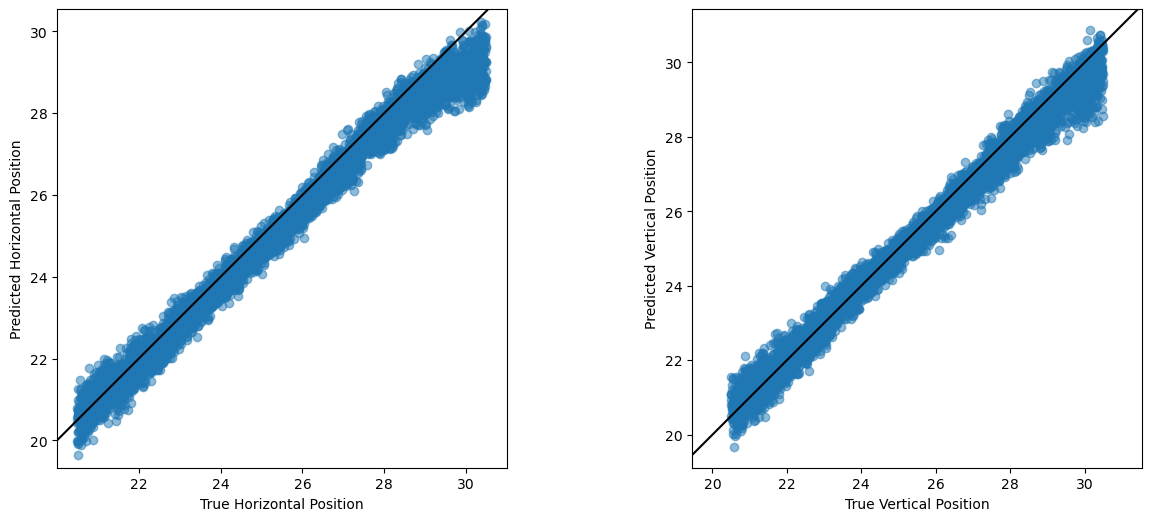

In [15]:
predictions = localizer(test_images).detach().numpy() + image_size / 2 - 0.5

plt.figure(figsize=(14, 8))
grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)


plt.subplot(grid[1:, :3])
plt.scatter(test_gt[:, 0], predictions[:, 0], alpha=.5) 
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Horizontal Position")
plt.ylabel("Predicted Horizontal Position")
plt.axis("equal")

plt.subplot(grid[1:, 4:])
plt.scatter(test_gt[:, 1], predictions[:, 1], alpha=.5)
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Vertical Position")
plt.ylabel("Predicted Vertical Position")
plt.axis("equal")


In [16]:
lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

trainer = dl.Trainer(max_epochs=100)
trainer.fit(lodestar, dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


(20.002353205923992,
 30.995317266979466,
 19.788950061798097,
 31.309146785736083)

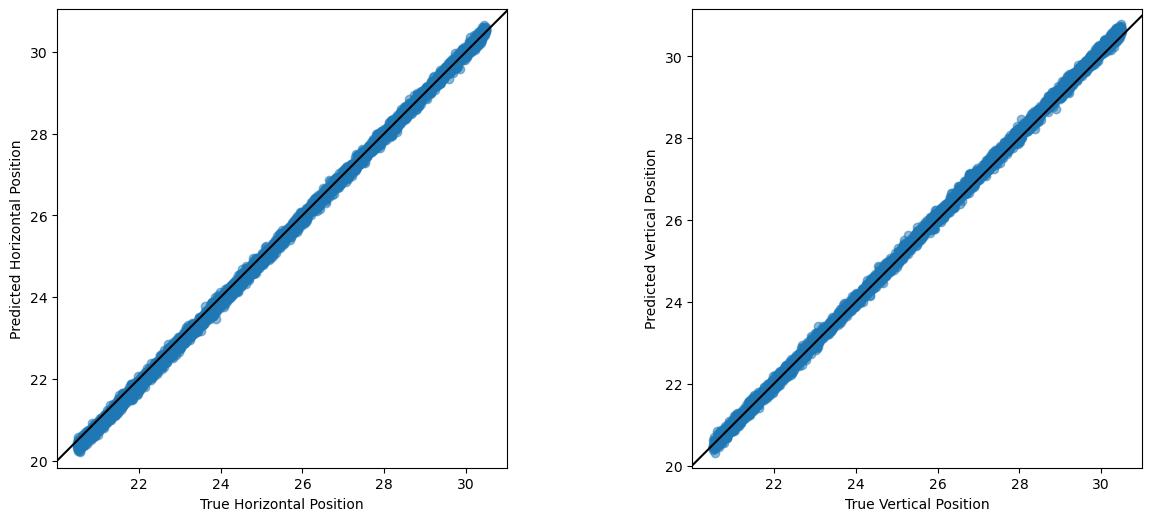

In [17]:
predictions = lodestar.pooled(test_images).detach().numpy()

plt.figure(figsize=(14, 8))
grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)


plt.subplot(grid[1:, :3])
plt.scatter(test_gt[:, 0], predictions[:, 0], alpha=.5) 
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Horizontal Position")
plt.ylabel("Predicted Horizontal Position")
plt.axis("equal")

plt.subplot(grid[1:, 4:])
plt.scatter(test_gt[:, 1], predictions[:, 1], alpha=.5)
plt.axline((25, 25), slope=1, color="black")
plt.xlabel("True Vertical Position")
plt.ylabel("Predicted Vertical Position")
plt.axis("equal")
